In [1]:
import pandas as pd
import numpy as np
from dateutil import parser
import isodate

# Data visualization libraries
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set(style="darkgrid", color_codes=True)

# Google API
from googleapiclient.discovery import build

In [2]:
# NLP libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('punkt')
from wordcloud import WordCloud

[nltk_data] Downloading package stopwords to C:\Users\Anupam
[nltk_data]     Gajbhiye/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Anupam
[nltk_data]     Gajbhiye/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [15]:
api_key='YOUR_YOUTUBE_API_KEY'
channel_ids=["UCIwFjwMjI0y7PDBVEO9-bkQ",#Justin Beiber
             "UC0C-w0YjGpqDXGB8IHb662A",#Ed sheeran
             "UCPNxhDvTcytIdvwXWAm43cA",#Selena Gomez
             "UC9CoOnJkIBMdeijd9qYoT_g",#Ariana Grande
             "UC0WP5P-ufpRfjbNrmOWwLBQ",#The Weekend
             "UCqECaJ8Gagnn7YCbPEzWH6g",#Taylor swift
             "UCAvCL8hyXjSUHKEGuUPr1BA",#Shawn mendez
             "UCfM3zsQsOnfWNUppiycmBuw",#Eminem
             "UCeLHszkByNZtPKcaVXOCOQQ",#Post Malone
             "UCByOQJjav0CUDwxCk-jVNRQ",#Drake
             "UCYLNGLIzMhRTi6ZOLjAPSmw",#Shakira
            ]

youtube = build('youtube', 'v3', developerKey=api_key)

In [16]:
def get_channel_stats(youtube, channel_ids):
    """
    Get channel statistics: title, subscriber count, view count, video count, upload playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    channels_ids: list of channel IDs
    
    Returns:
    Dataframe containing the channel statistics for all channels in the provided list: title, subscriber count, view count, video count, upload playlist
    
    """
    all_data = []
    request = youtube.channels().list(
                part='snippet,contentDetails,statistics',
                id=','.join(channel_ids))
    response = request.execute() 
    
    for i in range(len(response['items'])):
        data = dict(channelName = response['items'][i]['snippet']['title'],
                    subscribers = response['items'][i]['statistics']['subscriberCount'],
                    views = response['items'][i]['statistics']['viewCount'],
                    totalVideos = response['items'][i]['statistics']['videoCount'],
                    playlistId = response['items'][i]['contentDetails']['relatedPlaylists']['uploads'])
        all_data.append(data)
    
    return pd.DataFrame(all_data)

def get_video_ids(youtube, playlist_id):
    """
    Get list of video IDs of all videos in the given playlist
    Params:
    
    youtube: the build object from googleapiclient.discovery
    playlist_id: playlist ID of the channel
    
    Returns:
    List of video IDs of all videos in the playlist
    
    """
    
    request = youtube.playlistItems().list(
                part='contentDetails',
                playlistId = playlist_id,
                maxResults = 50)
    response = request.execute()
    
    video_ids = []
    
    for i in range(len(response['items'])):
        video_ids.append(response['items'][i]['contentDetails']['videoId'])
        
    next_page_token = response.get('nextPageToken')
    more_pages = True
    
    while more_pages:
        if next_page_token is None:
            more_pages = False
        else:
            request = youtube.playlistItems().list(
                        part='contentDetails',
                        playlistId = playlist_id,
                        maxResults = 50,
                        pageToken = next_page_token)
            response = request.execute()
    
            for i in range(len(response['items'])):
                video_ids.append(response['items'][i]['contentDetails']['videoId'])
            
            next_page_token = response.get('nextPageToken')
        
    return video_ids

def get_video_details(youtube, video_ids):
    """
    Get video statistics of all videos with given IDs
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with statistics of videos, i.e.:
        'channelTitle', 'title', 'description', 'tags', 'publishedAt'
        'viewCount', 'likeCount', 'favoriteCount', 'commentCount'
        'duration', 'definition', 'caption'
    """
        
    all_video_info = []
    
    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
            part="snippet,contentDetails,statistics",
            id=','.join(video_ids[i:i+50])
        )
        response = request.execute() 

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                             'statistics': ['viewCount', 'likeCount', 'favouriteCount', 'commentCount'],
                             'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            for k in stats_to_keep.keys():
                for v in stats_to_keep[k]:
                    try:
                        video_info[v] = video[k][v]
                    except:
                        video_info[v] = None

            all_video_info.append(video_info)
            
    return pd.DataFrame(all_video_info)

def get_comments_in_videos(youtube, video_ids):
    """
    Get top level comments as text from all videos with given IDs (only the first 10 comments due to quote limit of Youtube API)
    Params:
    
    youtube: the build object from googleapiclient.discovery
    video_ids: list of video IDs
    
    Returns:
    Dataframe with video IDs and associated top level comment in text.
    
    """
    all_comments = []
    
    for video_id in video_ids:
        try:   
            request = youtube.commentThreads().list(
                part="snippet,replies",
                videoId=video_id
            )
            response = request.execute()
        
            comments_in_video = [comment['snippet']['topLevelComment']['snippet']['textOriginal'] for comment in response['items'][0:10]]
            comments_in_video_info = {'video_id': video_id, 'comments': comments_in_video}

            all_comments.append(comments_in_video_info)
            
        except: 
            # When error occurs - most likely because comments are disabled on a video
            print('Could not get comments for video ' + video_id)
        
    return pd.DataFrame(all_comments)     

In [17]:
channel_data = get_channel_stats(youtube, channel_ids)

In [18]:
channel_data

,channelName,subscribers,views,totalVideos,playlistId
0,The Weeknd,32600000,23379309972,169,UU0WP5P-ufpRfjbNrmOWwLBQ
1,Selena Gomez,33600000,13011732529,188,UUPNxhDvTcytIdvwXWAm43cA
2,Drake,28100000,15317875305,58,UUByOQJjav0CUDwxCk-jVNRQ
3,Ed Sheeran,53500000,30365626094,378,UU0C-w0YjGpqDXGB8IHb662A
4,Justin Bieber,71600000,30607291451,249,UUIwFjwMjI0y7PDBVEO9-bkQ
5,EminemMusic,56900000,27082292998,156,UUfM3zsQsOnfWNUppiycmBuw
6,Shakira,43500000,27564242769,324,UUYLNGLIzMhRTi6ZOLjAPSmw
7,Shawn Mendes,30000000,12831200855,133,UUAvCL8hyXjSUHKEGuUPr1BA
8,Post Malone,25500000,14399804403,75,UUeLHszkByNZtPKcaVXOCOQQ
9,Ariana Grande,52700000,24002670036,147,UU9CoOnJkIBMdeijd9qYoT_g


In [19]:
# Convert count columns to numeric columns
numeric_cols = ['subscribers', 'views', 'totalVideos']
channel_data[numeric_cols] = channel_data[numeric_cols].apply(pd.to_numeric, errors='coerce')


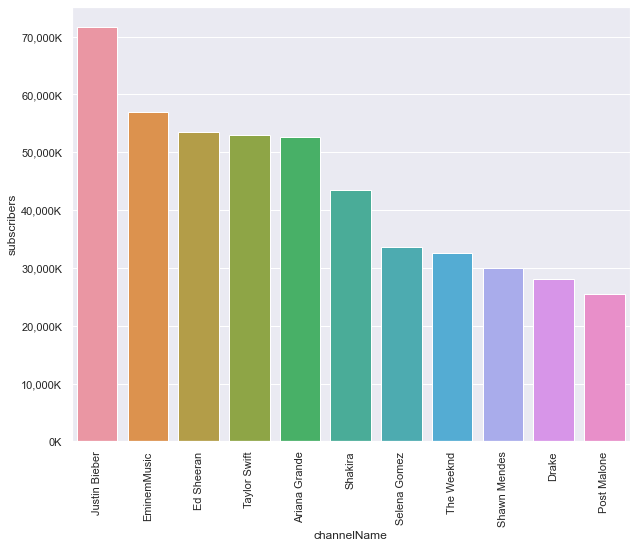

In [20]:
sns.set(rc={'figure.figsize':(10,8)})
ax = sns.barplot(x='channelName', y='subscribers', data=channel_data.sort_values('subscribers', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

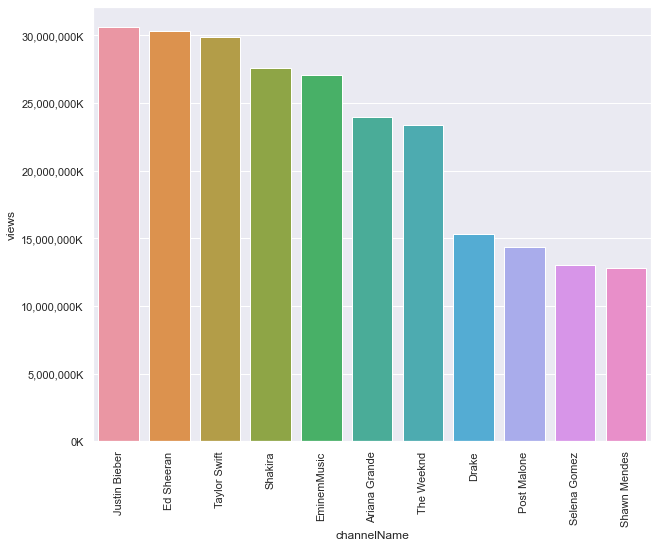

In [21]:
ax = sns.barplot(x='channelName', y='views', data=channel_data.sort_values('views', ascending=False))
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x/1000) + 'K'))
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)

In [22]:
# Create a dataframe with video statistics and comments from all channels

video_df = pd.DataFrame()


for c in channel_data['channelName'].unique():
    print("Getting video information from channel: " + c)
    playlist_id = channel_data.loc[channel_data['channelName']== c, 'playlistId'].iloc[0]
    video_ids = get_video_ids(youtube, playlist_id)
    
    # get video data
    video_data = get_video_details(youtube, video_ids)
    

    # append video data together and comment data toghether
    video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: The Weeknd


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Selena Gomez


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Drake


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Ed Sheeran


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Justin Bieber


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: EminemMusic


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Shakira


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Shawn Mendes


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Post Malone


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Ariana Grande


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


Getting video information from channel: Taylor Swift


C:\Users\Anupam Gajbhiye\AppData\Local\Temp\ipykernel_44752\2218379443.py:16: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  video_df = video_df.append(video_data, ignore_index=True)


In [23]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption
0,p1D7pg-vtf0,The Weeknd,The Weeknd - Like A God (Music from the HBO Or...,Available to stream + download now: http://the...,None,2023-07-06T19:44:52Z,213529,11958,None,639,PT3M49S,hd,false
1,Mx92lTYxrJQ,TheWeekndVEVO,"The Weeknd, JENNIE, Lily-Rose Depp - One Of Th...","Official audio for ""One Of The Girls"", availab...","[The, Weeknd, JENNIE, Lily, Rose, Depp, One, G...",2023-07-06T14:00:13Z,3511123,230107,None,6858,PT4M19S,hd,true
2,rccD5TC5g_o,The Weeknd,The Weeknd & Lily-Rose Depp – Dollhouse (Offic...,Available to stream + download now: http://the...,None,2023-07-03T04:00:32Z,670314,24433,None,956,PT4M,hd,false
3,XsFDcdHGXSc,The Weeknd,Troye Sivan – My Sweet Lord (Official Audio),Available to stream + download now: http://the...,None,2023-07-03T04:00:23Z,170719,9177,None,448,PT3M13S,hd,false
4,_rwtRKFhwtM,The Weeknd,Suzanna Son - Crocodile Tears (Official Audio),Available to stream + download now: http://the...,None,2023-07-03T04:00:19Z,99081,5675,None,265,PT3M3S,hd,false
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3797,Mi-FBBqUuJE,Taylor Swift,First fans with my CMT Award.,I made you a promise to bring my CMT Award out...,"[Taylor, Swift, CMT, Award, Fans]",2008-06-26T21:55:43Z,315989,2985,None,208,PT11S,sd,false
3798,p-5R0u3iTiE,Taylor Swift,TRL Recap!,I took my camera to TRL -- this is the result....,"[Taylor, Swift, TRL, MTV, Total, Request, Live...",2008-06-26T21:15:51Z,707629,6903,None,752,PT3M8S,sd,false
3799,C7I3_yFQYkc,Taylor Swift,Wannabe,Wannabe\n\nShop music here: http://smarturl.it...,"[Taylor, Swift, Wannabe, Spice, Girls]",2008-06-26T21:02:39Z,1173543,16852,None,1417,PT3M45S,sd,false
3800,pA1dPsnfams,Taylor Swift,:-),Unexplainable.\n\nShop music here: http://smar...,"[Taylor, Swift, Kellie, Pickler, Funny]",2008-06-26T20:51:09Z,700839,13398,None,1068,PT34S,sd,false


In [24]:
# Write video data to CSV file for future references
video_df.to_csv('video_data_top10_chann.csv')

# Preprocessing & Feature Engineering

 In order to analyze the data effectively, certain pre-processing steps are required. Firstly, it is important to reformat specific columns, particularly those related to dates and times such as "publishedAt" and "duration". By doing so, the data will be in a standardized and consistent format, making it easier to work with.

 Additionally, it is beneficial to enrich the dataset by introducing new features that can provide valuable insights into the characteristics of the videos. These new features will contribute to a better understanding of the data and enhance the analysis process.

## Checking empty values:

In [25]:
video_df.isnull().sum()

video_id             0
channelTitle         0
title                0
description          0
tags               438
publishedAt          0
viewCount            6
likeCount           18
favouriteCount    3802
commentCount        23
duration             0
definition           0
caption              0
dtype: int64

In [26]:
video_df.publishedAt.sort_values().value_counts()

2019-12-23T07:02:08Z    17
2022-01-09T06:43:08Z    12
2012-06-18T15:40:07Z     9
2011-11-01T07:00:00Z     9
2012-10-29T15:45:07Z     7
                        ..
2014-08-13T00:55:01Z     1
2014-08-15T17:05:41Z     1
2014-08-18T14:05:42Z     1
2014-08-18T21:18:00Z     1
2023-07-11T20:00:41Z     1
Name: publishedAt, Length: 3513, dtype: int64

In the next step, it is important to verify the correctness of the data types for the columns. After reviewing the data types, it has been observed that certain count columns, such as view count and comment count, are currently not in the correct data type. To rectify this, we need to convert these count columns into integers. By performing this conversion, we ensure that the data accurately represents the count values.

In [29]:
cols = ['viewCount', 'likeCount',  'commentCount']
video_df[cols] = video_df[cols].apply(pd.to_numeric, errors='coerce', axis=1)

# To enhance the data for subsequent analysis, the following enrichments can be performed:


1. Calculating the character length of the video titles. By quantifying the length of the titles, we can analyze potential relationships between title length and various video characteristics, such as popularity or viewer engagement.


2. Computing the ratio of likes per 1000 views. This ratio will provide a normalized perspective on the engagement level of each video, considering the number of views as a reference point.


3. Calculating the number of tags associated with each video. By determining the count of tags, we can gain insights into the level of metadata richness and the extent of keyword associations for each video.


4. Converting the video duration from its current string format to a standardized format representing the duration in seconds. This transformation will allow for easier comparisons and calculations based on the duration of each video.


5. Create a new column called "Published Date" that includes the day of the week the video was published. This additional column will provide valuable information for later analysis, enabling insights based on the publishing patterns across different days of the week.

In [30]:
# Title character length
video_df['titleLength'] = video_df['title'].apply(lambda x: len(x))

In [31]:
#Likes per 1000 view ratio
video_df['likeRatio'] = (video_df['likeCount']/ video_df['viewCount']) * 1000

In [32]:
# Add number of tags
video_df['tagsCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))

In [34]:
# convert duration to seconds
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')

In [35]:
# Create publish day (in the week) column
video_df['publishedAt'] =  video_df['publishedAt'].apply(lambda x: parser.parse(x)) 
video_df['pushblishDayName'] = video_df['publishedAt'].apply(lambda x: x.strftime("%A")) 


Now, let's examine the video dataset to verify that the previous steps were executed successfully. Upon inspection, it appears that everything went smoothly, and the dataset is in good shape. The necessary data transformations and enrichments have been applied, enabling us to proceed to the next phase: exploratory analysis. This phase involves delving into the dataset to extract meaningful insights and gain a deeper understanding of the video data.


In [36]:
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,favouriteCount,commentCount,duration,definition,caption,titleLength,likeRatio,tagsCount,durationSecs,pushblishDayName
0,p1D7pg-vtf0,The Weeknd,The Weeknd - Like A God (Music from the HBO Or...,Available to stream + download now: http://the...,None,2023-07-06 19:44:52+00:00,213529.0,11958.0,None,639.0,PT3M49S,hd,false,69,56.001761,0,229.0,Thursday
1,Mx92lTYxrJQ,TheWeekndVEVO,"The Weeknd, JENNIE, Lily-Rose Depp - One Of Th...","Official audio for ""One Of The Girls"", availab...","[The, Weeknd, JENNIE, Lily, Rose, Depp, One, G...",2023-07-06 14:00:13+00:00,3511123.0,230107.0,None,6858.0,PT4M19S,hd,true,70,65.536582,11,259.0,Thursday
2,rccD5TC5g_o,The Weeknd,The Weeknd & Lily-Rose Depp – Dollhouse (Offic...,Available to stream + download now: http://the...,None,2023-07-03 04:00:32+00:00,670314.0,24433.0,None,956.0,PT4M,hd,false,56,36.450082,0,240.0,Monday
3,XsFDcdHGXSc,The Weeknd,Troye Sivan – My Sweet Lord (Official Audio),Available to stream + download now: http://the...,None,2023-07-03 04:00:23+00:00,170719.0,9177.0,None,448.0,PT3M13S,hd,false,44,53.755001,0,193.0,Monday
4,_rwtRKFhwtM,The Weeknd,Suzanna Son - Crocodile Tears (Official Audio),Available to stream + download now: http://the...,None,2023-07-03 04:00:19+00:00,99081.0,5675.0,None,265.0,PT3M3S,hd,false,46,57.276370,0,183.0,Monday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3797,Mi-FBBqUuJE,Taylor Swift,First fans with my CMT Award.,I made you a promise to bring my CMT Award out...,"[Taylor, Swift, CMT, Award, Fans]",2008-06-26 21:55:43+00:00,315989.0,2985.0,None,208.0,PT11S,sd,false,29,9.446531,5,11.0,Thursday
3798,p-5R0u3iTiE,Taylor Swift,TRL Recap!,I took my camera to TRL -- this is the result....,"[Taylor, Swift, TRL, MTV, Total, Request, Live...",2008-06-26 21:15:51+00:00,707629.0,6903.0,None,752.0,PT3M8S,sd,false,10,9.755112,14,188.0,Thursday
3799,C7I3_yFQYkc,Taylor Swift,Wannabe,Wannabe\n\nShop music here: http://smarturl.it...,"[Taylor, Swift, Wannabe, Spice, Girls]",2008-06-26 21:02:39+00:00,1173543.0,16852.0,None,1417.0,PT3M45S,sd,false,7,14.359934,5,225.0,Thursday
3800,pA1dPsnfams,Taylor Swift,:-),Unexplainable.\n\nShop music here: http://smar...,"[Taylor, Swift, Kellie, Pickler, Funny]",2008-06-26 20:51:09+00:00,700839.0,13398.0,None,1068.0,PT34S,sd,false,3,19.117087,5,34.0,Thursday


So now, we have a detailed dataset, that is made from scratch. (Not scratch, but APIs XD)
We can now perform data analysis on this dataset.

# Exploratory Data Analysis: EDA


With the availability of video statistics for all channels, we can now observe how views are distributed across each channel. Some channels may have a significant number of views on a specific video, while the remaining videos do not receive many views. On the other hand, some channels might have a more evenly distributed number of views across their videos.

C:\Users\Anupam Gajbhiye\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


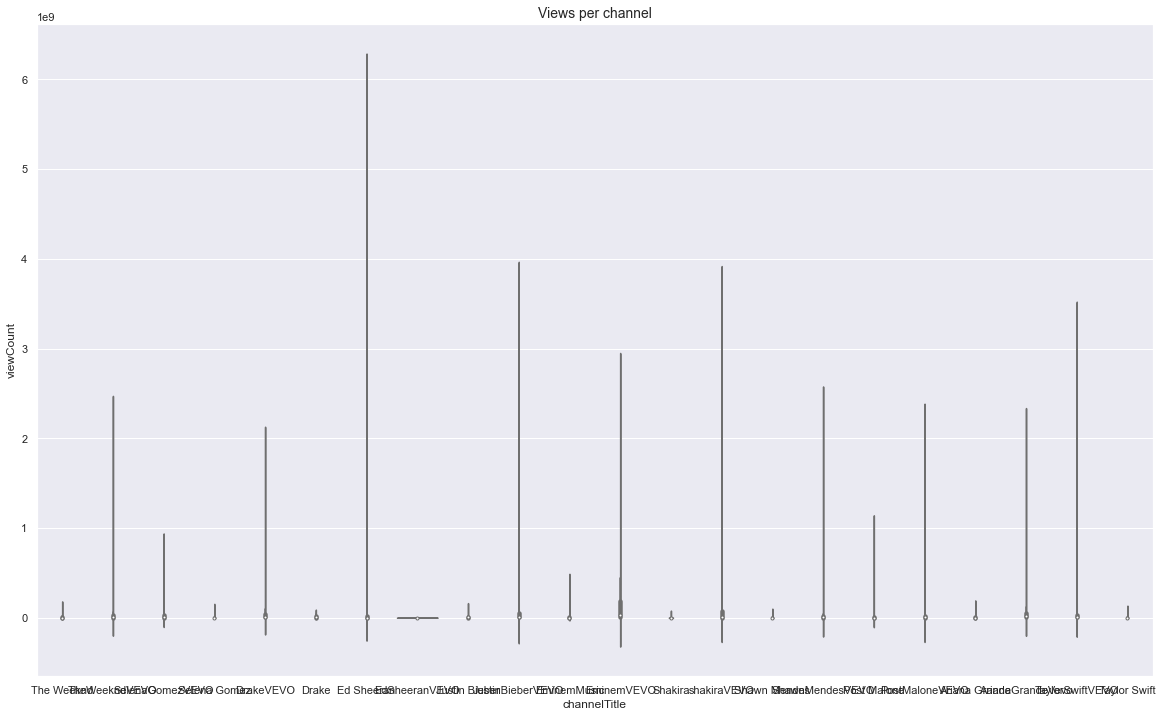

In [42]:
plt.rcParams['figure.figsize'] = (20, 12)
sns.violinplot(video_df['channelTitle'], video_df['viewCount'], palette = 'pastel')
plt.title('Views per channel', fontsize = 14)
plot = ax.set_xticklabels(ax.get_xticklabels(),rotation = 90)
plt.show()

### Does the number of likes and comments matter for a video to get more views?

To determine if the number of likes and comments have an impact on the number of views a video receives, I will conduct an analysis. Initially, I will examine the correlation between views and the number of comments/likes. The plots below demonstrate a strong correlation between the number of views and the number of comments/likes. It appears that the number of likes exhibits a stronger correlation compared to the number of comments. However, this outcome is expected since a higher number of viewers increases the likelihood of receiving comments and likes. To account for this factor, I will replot the relationships using ratios such as comments per 1000 views and likes per 1000 views.


<AxesSubplot:xlabel='likeCount', ylabel='viewCount'>

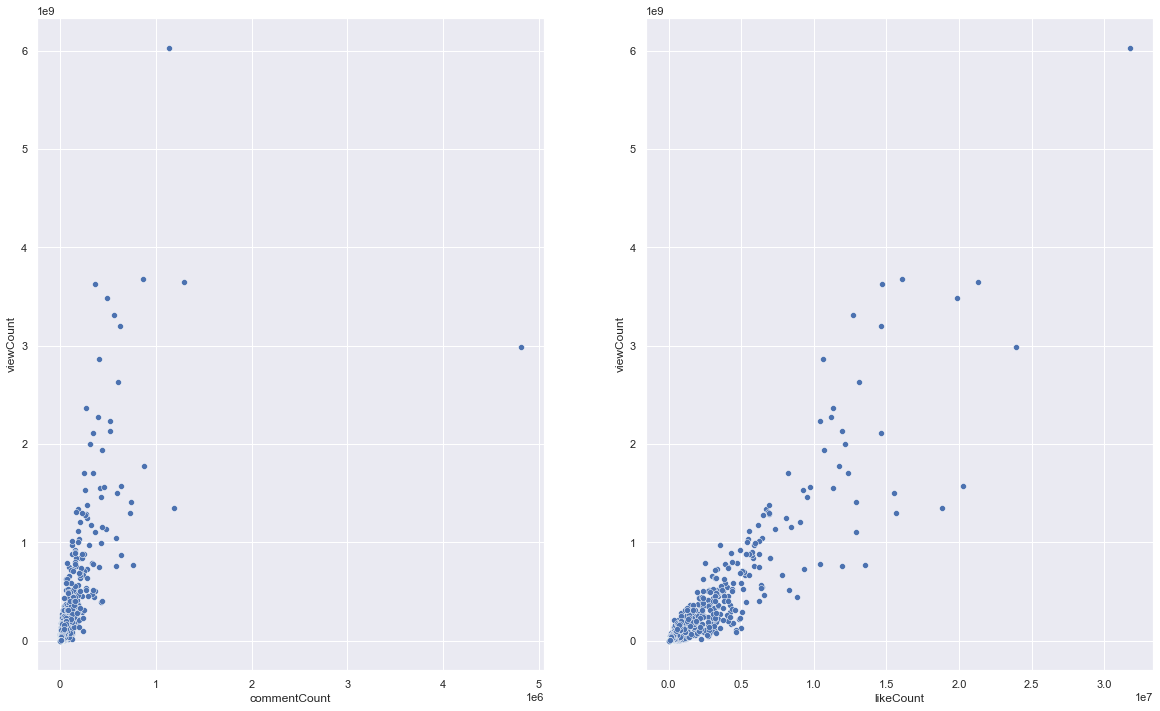

In [43]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "commentCount", y = "viewCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "likeCount", y = "viewCount", ax=ax[1])

The comment-view relationship seems to completely disappear: a lot of videos have millions of views and very few comments, while some vides have very few views have better interaction. However, it is understandable that comments take more effort than views and likes, and normally comments would die off when the video gets older.

### Does the video duration matter for views and interaction (likes/ comments)?

<AxesSubplot:xlabel='durationSecs', ylabel='Count'>

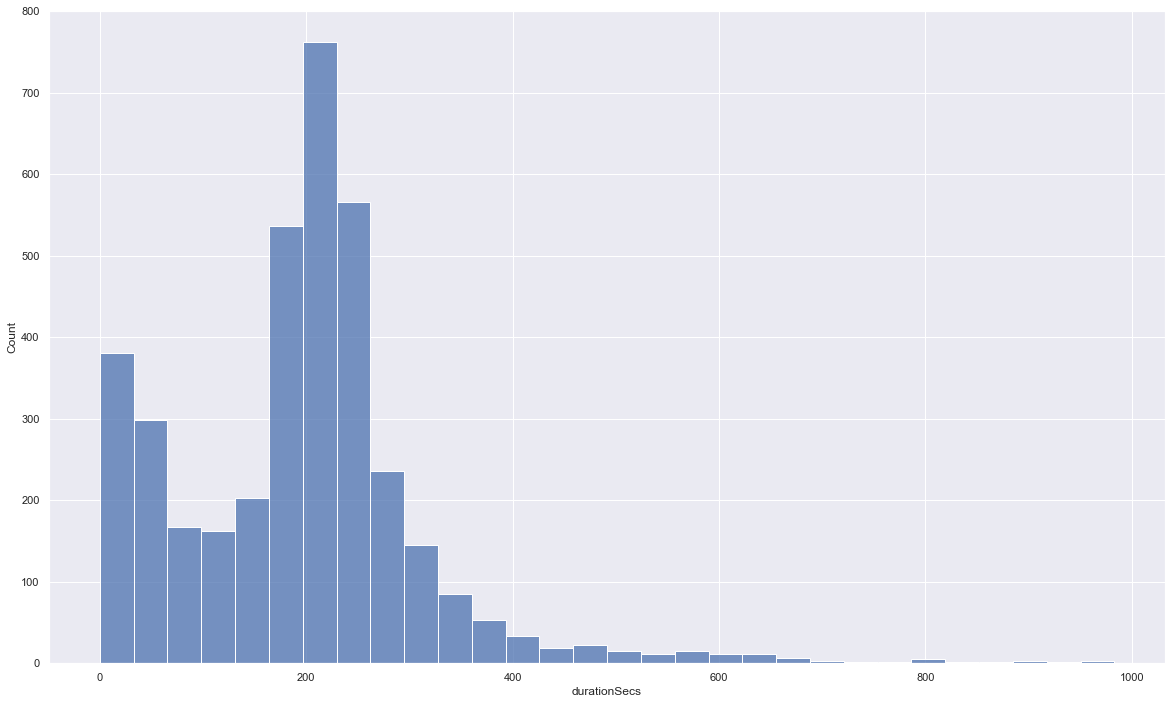

In [52]:
sns.histplot(data=video_df[video_df['durationSecs'] < 1000], x="durationSecs", bins=30)


As can be seen in the histogram below, most videos are between 150 and 300 seconds, which is about 2.5 to 5 minutes.As expected of song videos

<AxesSubplot:xlabel='durationSecs', ylabel='likeCount'>

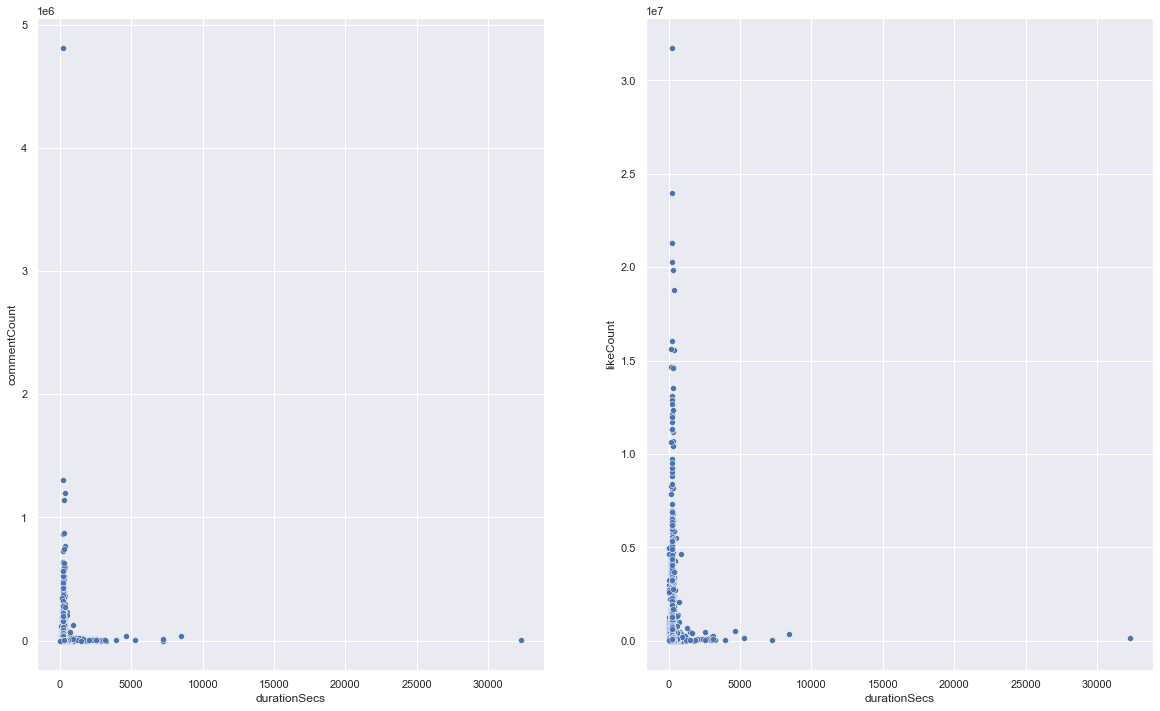

In [53]:
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x = "durationSecs", y = "commentCount", ax=ax[0])
sns.scatterplot(data = video_df, x = "durationSecs", y = "likeCount", ax=ax[1])


Now we plot the duration against comment count and like count. It can be seen that actually shorter videos tend to get more likes and comments than very long videos.

### Does title length matter for views?

There is no clear relationship between title length and views as seen the scatterplot below, but most-viewed videos tend to have average title length of 30-70 characters.

<AxesSubplot:xlabel='titleLength', ylabel='viewCount'>

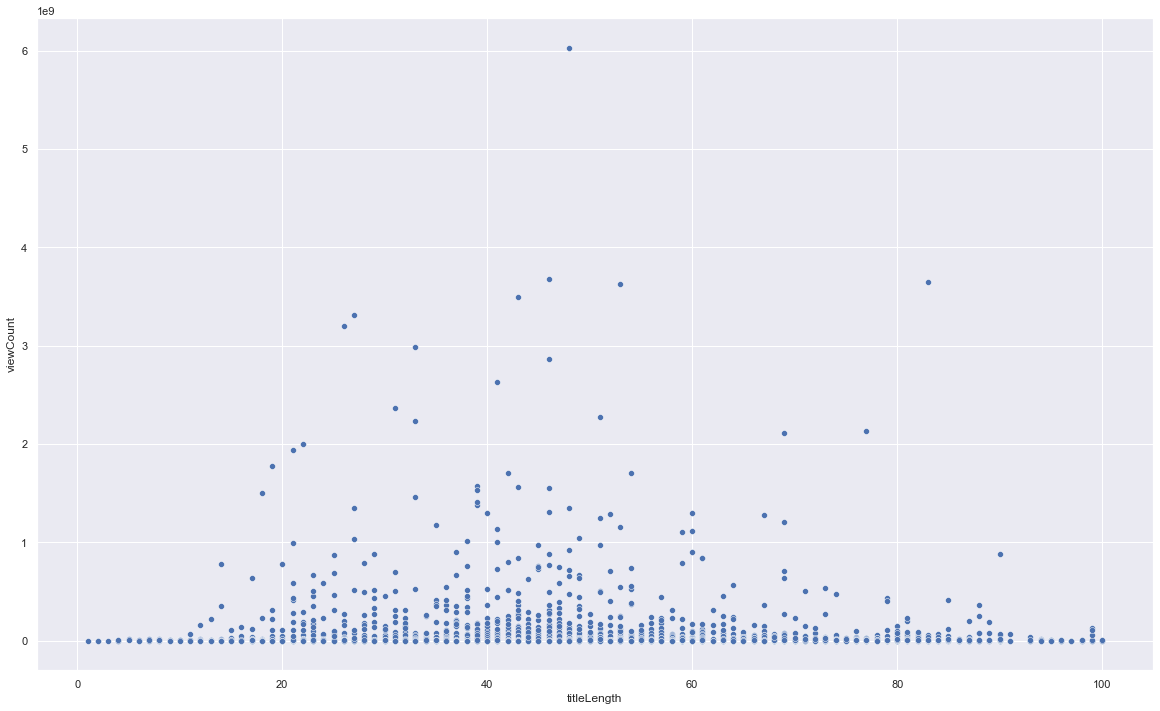

In [54]:
sns.scatterplot(data = video_df, x = "titleLength", y = "viewCount")


### Wordcloud for words in title


To gain insights into the content of the creators' videos and identify the most frequently used terms in their video titles, I will generate a word cloud. However, before creating the word cloud, it is essential to remove stopwords. Stopwords are commonly used words such as "you," "I," "the," and others that do not significantly contribute to the meaning of the title. By eliminating these stopwords, we can focus on the more meaningful and relevant words in the video titles.

In [55]:
stop_words = set(stopwords.words('english'))
video_df['title_no_stopwords'] = video_df['title'].apply(lambda x: [item for item in str(x).split() if item not in stop_words])

all_words = list([a for b in video_df['title_no_stopwords'].tolist() for a in b])
all_words_str = ' '.join(all_words) 

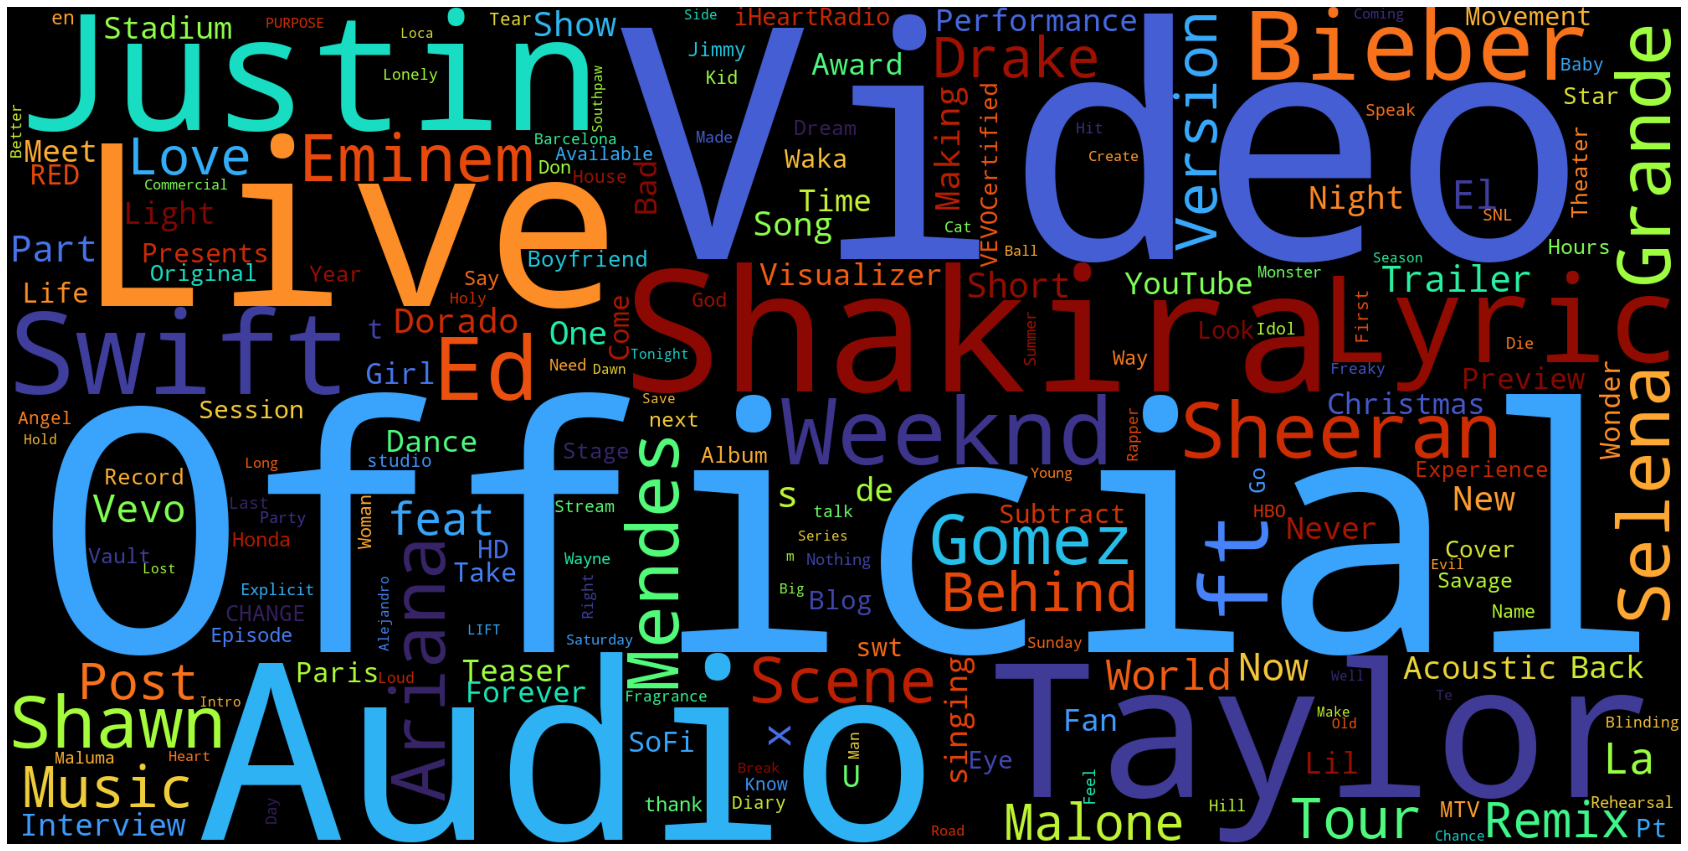

In [59]:
def plot_cloud(wordcloud):
    plt.figure(figsize=(30, 20))
    plt.imshow(wordcloud) 
    plt.axis("off");

wordcloud = WordCloud(width = 2000, height = 1000, random_state=1, background_color='black', 
                      colormap='turbo_r', collocations=False).generate(all_words_str)
plot_cloud(wordcloud)

So most common words are, Official, Shakira, Video, Live, Audio

### Which day in the week are most videos uploaded?

It is fascinating to observe that there is a higher influx of video uploads on Mondays and Fridays, while the number of uploads decreases over the weekend. One possible explanation for this trend is that the nature of the content uploaded is often focused on songs, which may align with the leisurely consumption patterns typically associated with weekends. Alternatively, it could signify that many creators dedicate their time to producing videos during the weekend or throughout the week and choose to release them at the beginning of the week or on Fridays.

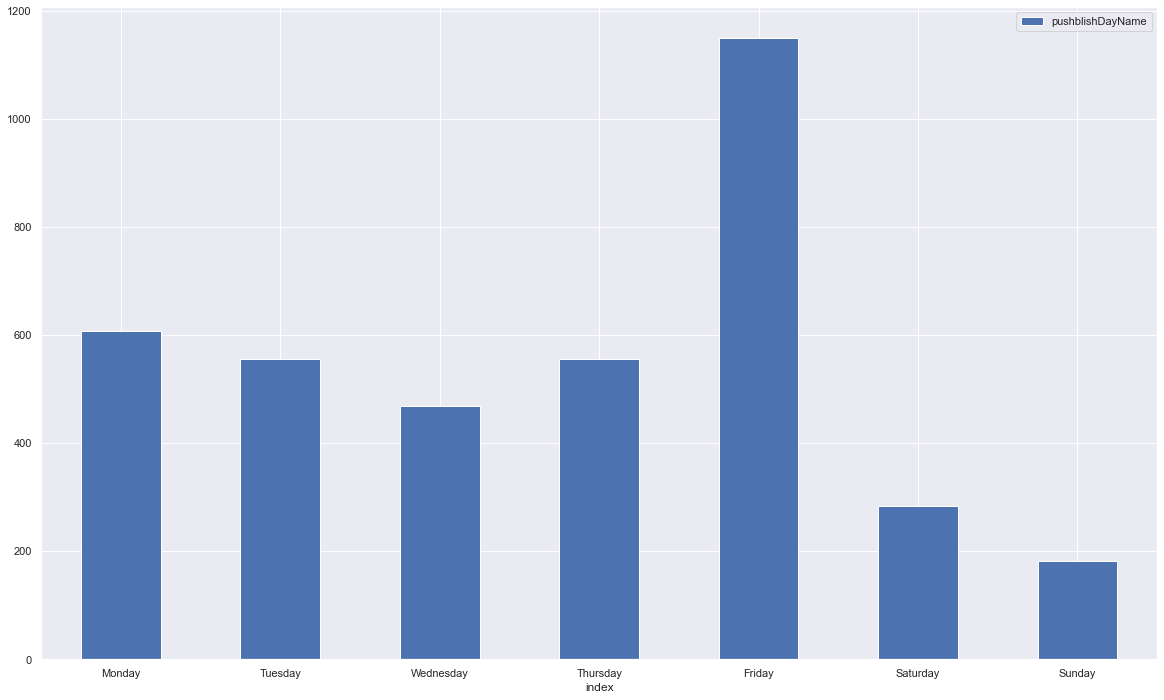

In [61]:
day_df = pd.DataFrame(video_df['pushblishDayName'].value_counts())
weekdays = [ 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
day_df = day_df.reindex(weekdays)
ax = day_df.reset_index().plot.bar(x='index', y='pushblishDayName', rot=0)

# Conclusions :

1) The more likes and comments a video has, the more views the video gets (it is not guaranteed that this is a causal relationship, it is simply a correlation and can work both way). Likes seem to be a better indicator for interaction than comments and the number of likes seem to follow the "social proof", which means the more views the video has, the more people will like it.

2) Most-viewed videos tend to have average title length of 30-70 characters. Too short or too long titles seem to harm viewership.

3) Videos are usually uploaded on Mondays and Fridays. Weekends and Sunday in particular is not a popular time for posting new videos.

4) most videos are between 150 and 300 seconds, which is about 2.5 to 5 minutes.As expected of song videos